# PyParseis-LMFIT.ipynb

Invert parallel seismic first arrival data to retrieve pile foundation parameters.

Based on Ernst Niederleithinger's PhD thesis (2010, U Potsdam/BAM):
"Optimierung und Erweiterung der Parallel-Seismik-Methode zur Bestimmung der Länge von Fundamentpfählen" 
https://opus4.kobv.de/opus4-bam/frontdoor/index/index/year/2015/docId/88

<img src="ParSeis-principle.jpg">
<i>Principle of Parallel Seismsic Measurements</i>

Niederleithinger BAM 8.2 2025/2026

Last change(s):
<ul>
<li>Niederleithinger 19.08.2025 Converted to Jupyter notebook</li>
<li>Niederleithinger 02.12.2025 Replaced scipy.least_squares by lmfit
<li>Niederleithinger 31.01.2026 Inclination (PSfei from PyparSeis.py) 
</ul>

Note 1: Start Jupyter notebook from the directory which contains the PyParSeis files (otherwise PyParSeis.py and imagees for the markdown cell will not be found)

Note 2:Installation of lmfit, numdifftools required  (at prompt: "pip install lmfit" etc.) 


Credits for lmfit: https://doi.org/10.5281/zenodo.598352, source and documentation: https://lmfit.github.io/lmfit-py/ 


Next cell does the the import stuff, defines the function to minimize and the fuction to read measured data from file 


In [1]:
# -*- coding: utf-8 -*-
#!/usr/bin/python

from math import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.text as pltext

from lmfit import minimize, Parameters, report_fit

from PyParSeis import PSfe, PSfei

# function to read first arrival data from ASCII text file
def load_data(filename):
        with open(filename,'r') as file:
                 dat = np.loadtxt(file)
        return dat

# Fit function
# difference of traveltimes caculated (from current model) to measured ones

def residual(params, z, fat, uncertainty=1):
    R = params['R']
    D = params['D']
    cp = params['cp']
    cs = params['cs']
    L = params['L']
    off = params['off']
    inc = params['inc']

    # model = PSfe(R,D,z,cp,cs,L,off) # without inclination
    model = PSfei(R,D,z,cp,cs,L,off,inc) # with inclination

    return (fat-model) / uncertainty



# Load data, set inversion parameters


<ul>
Data need to be in a 2 or 3 column ASCII file
<li>First column: z (sensors depth relative to pile head, positive downwards, in m)</li>
<li>Second column: fat (first arrival time, in ms)</li>
<li>Optional: Third column: uncertainties for first arrival time (have to be > 0)    
</ul>

Uncertainties serve as weigthing factors for the residuals (high uncertainty = low weight) in the inversion. Uuncertainties can't be zero! If uncertainties are not given in input file, they will be set to one.

<ul>
Paramters are stored in the params list: 
<li>R  : pile radius in m</li>
<li>D  : distance pile edge - sensor in m</li>
<li>cppile : p-wave velocity in pile in m/s (actually a stress wave, close to a bar wave)</li>
<li>cpsoil : p-wave velocity in soil in m/s</li>
<li>L  : pile length in m</li>
<li>off: time offset in s (constant added to all travel times, e.g. to mimick trigger or picking errors)</li>
<li>inc: inclination (borehole vs. pile, 2D) in deg NOT SUPPORTED IN CURRENT VERSION of PyParSeis</li>
</ul>
Parameters can be fixed (R and D always, inc recommended) or constrained.


In [2]:
# load data and set initial parameters
filename ='PyParseisModel-R0.30-D0.50-L11.00-cp4200-cs1500-off0.50-inc0.00-noiseamp0.20.dat' 

data = load_data(filename)
z = data[:,0]
fat = data[:,1]/1000 # as fat is given in ms in file
if (len(data[0])>2):
    uncertainty = data[:,2] # uncertainties of fat data 
else:
    uncertainty = np.ones(len(data))
    
# uncertainties for each data value:
# these uncertainties serve as weigthing factors for the residuals (high uncertainty = low weight) in the inversion
# array with length = number of parameters
# uncertainties can't be zero!
# if uncertainties are not given in input file, they will be set to one


#set parameters with starting values, bounds and fixes
# values used as starting values for inversion
# vary = false: fixed parameter (you can fix any)
# R and D always fixed, inc recommended to be fixed
# you can set min and max values for each parameter by adding ",min = minvalue, max = maxvalue")

params = Parameters()          
params.add('R', value=0.3, vary=False)               # pile radius in m
params.add('D', value=0.5, vary=False)               # distance pile edge - sensor in m
params.add('cp', value=4300)                         # concrete p-wave velocity in m/s
params.add('cs', value=1500)                         # soil p-wave velocity  in m/s
params.add('L', value=9.0, min = 6.0, max =15.0)     # pile length in m with reasonable limits
params.add('off', value=0.0/1000)                    # time offset in s
params.add('inc', value=0.0, vary=False)             # inclination in deg


# Inversion

The inversion is performed either by the Levenberg-Marquardt method as implemented in the libraray lmfit:
This is a change to version 0.2 of PyParSeis, which relied on the implementation from scipy.
Now, bounds and parameter fixing are suported as well as the implementation of uncertainties.

See https://lmfit.github.io/lmfit-py/index.html for details


In [3]:
# evaluate start model
Rs = params['R']
Ds = params['D']
cppiles = params['cp']
cpsoils = params['cs']
Ls = params['L']
offs = params['off']
incs = params['inc']


tstart = PSfei(Rs.value,Ds.value,z,cppiles.value,cpsoils.value,Ls.value,offs.value,incs.value)

# fit and print results
result = minimize(residual, params, args=(z, fat))
report_fit(result)

#evaluate fit model
R = result.params['R']
D = result.params['D']
cppile = result.params['cp']
cpsoil = result.params['cs']
L = result.params['L']
off = result.params['off']
inc = result.params['inc']

tfit = PSfei(R.value,D.value,z,cppile.value,cpsoil.value,L.value,off,inc)


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 29
    # variables        = 4
    chi-square         = 9.8212e-08
    reduced chi-square = 3.9285e-09
    Akaike info crit   = -557.599557
    Bayesian info crit = -552.130373
[[Variables]]
    R:    0.3 (fixed)
    D:    0.5 (fixed)
    cp:   4174.06336 +/- 78.2802009 (1.88%) (init = 4300)
    cs:   1528.51039 +/- 58.4983061 (3.83%) (init = 1500)
    L:    11.0213612 +/- 0.16224221 (1.47%) (init = 9)
    off:  5.0015e-04 +/- 3.3256e-05 (6.65%) (init = 0)
    inc:  0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(cp, off) = +0.8306
    C(cs, L)   = -0.8245
    C(L, off)  = -0.5825
    C(cs, off) = +0.4588
    C(cp, L)   = -0.4541
    C(cp, cs)  = +0.1002
Parameters([('R', <Parameter 'R', value=0.3 (fixed), bounds=[-inf:inf]>), ('D', <Parameter 'D', value=0.5 (fixed), bounds=[-inf:inf]>), ('cp', <Parameter 'cp', value=4174.063357525247 +/- 78.3, bounds=[-inf:inf

# Plot calculated travel times

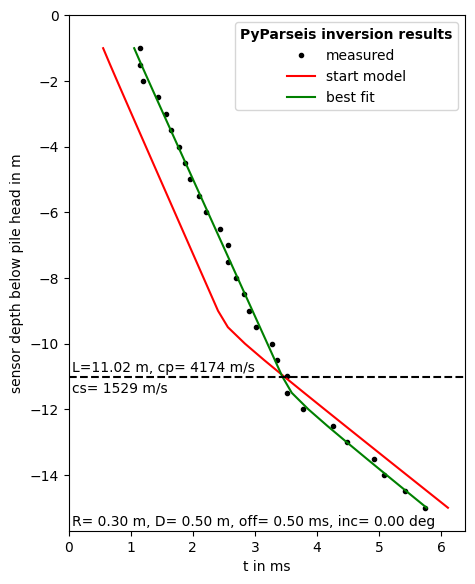

In [4]:
# To do: plot model geometry


cm2inch=1/2.54
fig = plt.figure(figsize=(13*cm2inch,17*cm2inch))

plt.plot(fat*1000, -z, 'ok', label='measured', markersize=3)
plt.plot(tstart*1000, -z, '-r', label='start model')
plt.plot(tfit*1000, -z, '-g', label='best fit')

xmin, xmax, ymin, ymax = plt.axis()
plt.axis([0, xmax,ymin,0])

plt.xlabel("t in ms")
plt.ylabel("sensor depth below pile head in m")
plt.legend(title='PyParseis inversion results',title_fontproperties={'weight':'bold'})
plt.plot([0,xmax],[-L.value,-L.value],ls='--', marker='', color ='k')
plt.text(xmax/100, -L.value-ymin*0.01, 'L=%5.2f m, cp=%5.0f m/s' % (L.value, cppile.value))
plt.text(xmax/100, -L.value+ymin*0.03, 'cs=%5.0f m/s' % (cpsoil.value))
plt.text(xmax/100, ymin*0.99, 'R=%5.2f m, D=%5.2f m, off=%5.2f ms, inc=%5.2f deg' % (R.value,D.value,off.value*1000,inc.value))
plt.savefig('parseis-fit.png', dpi = 300)
plt.show()
plt.close()

# The end 

In [5]:
#  The end